In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings

# Suppress only the RuntimeWarning for overflow
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
Data = pd.read_csv("Datasets/banknote/data_banknote_authentication.csv")
Data = Data.to_numpy()

In [3]:
m, n = Data.shape
n0 = n - 1

In [4]:
np.random.seed(14)

randseq = np.random.permutation(m)
Data = Data[randseq[0:m], 0:n]

In [5]:
trainval = math.floor(m*0.8)
testval = m - trainval

In [6]:
FeaturesServer = 2

NumberOfHorClients = 10

if FeaturesServer > 0 and FeaturesServer < n0:

    Data_server = Data[0:trainval, FeaturesServer:n]
    pd.DataFrame(Data_server).to_csv("data_split/data_split_ser.csv", header=False, index=False)

    datapoints = int(np.round(trainval/NumberOfHorClients))

    samples = np.zeros(NumberOfHorClients)

    for i in range(np.size(samples) - 1):
        SplitData_hor = Data[(i*datapoints):((i+1)*datapoints), 0:FeaturesServer]
        pd.DataFrame(SplitData_hor).to_csv("data_split/data_split_hor_"+str(i+1)+ ".csv", header=False, index=False)
        
    SplitData_hor = Data[(NumberOfHorClients-1)*datapoints:trainval, 0:FeaturesServer]
    pd.DataFrame(SplitData_hor).to_csv("data_split/data_split_hor_"+str(NumberOfHorClients)+ ".csv", header=False, index=False)

else:
    raise Exception("Number of features for registry should be greater than 0 and less than "+str(n0))

In [7]:
X_test = Data[trainval:m+1, 0:n0].T
y_test = Data[trainval:m+1, n0].reshape(1, m-trainval)

In [8]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [9]:
L = 4
nx = np.array([n0, 5, 5, 1])

In [10]:
# The server initializes the global model

W1_ser = np.random.randn(nx[1], 2)

b1 = np.random.randn(nx[1],1)

W2 = np.random.randn(nx[2],nx[1])
b2 = np.random.randn(nx[2],1)

W3 = np.random.randn(nx[3],nx[2])
b3 = np.random.randn(nx[3],1)

# W1 for the horizontal client

W1_hor = np.random.randn(nx[1], 2) 

In [11]:
learning_rate = 0.05
rounds = 1000

Avg_Loss = np.zeros((rounds,1))
Accuracy = np.zeros((rounds,1))

for r in range(rounds):

    Z1_con = np.empty((nx[1], 0))

    # Forward Propagation at each horizontal client
    for user in range(NumberOfHorClients):

        Data_hor = pd.read_csv("data_split/data_split_hor_"+str(user+1)+".csv", header=None)
        Data_hor = Data_hor.to_numpy()

        m_X, n_X = Data_hor.shape
        n0_loc = n_X

        X_hor_train = Data_hor[:, 0:n0_loc].T

        # Each horizontal client will send this Z1_hor to the server
        Z1_hor = np.dot(W1_hor, X_hor_train)
    
        # The server will concatenate all the Z1_hor 
        # into one matrix as follows
        Z1_con = np.concatenate((Z1_con, Z1_hor), axis=1) 
    
    # At server
    Data_X = pd.read_csv("data_split/data_split_ser.csv", header=None)
    Data_X = Data_X.to_numpy()

    m_X, n_X = Data_X.shape
    n0 = n_X - 1

    X_train = Data_X[:, 0:n0].T
    y_train = Data_X[:, n0].reshape(1, m_X)

    Z1_ser = np.dot(W1_ser, X_train)

    Z1_t = Z1_con + Z1_ser

    # Forward propagation
    Z1 = Z1_t + b1
    A1 = sigmoid(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    # J[i] = (-1/m_X)*np.sum(y_train*np.log(A3) + (1-y_train)*np.log(1-A3))
    
    # Backward propagation
    dZ3 = A3-y_train
    dW3 = (1/m_X)*np.dot(dZ3, A2.T)
    db3 = (1/m_X)*np.sum(dZ3, axis = 1, keepdims = True)

    dA2 = A2*(1-A2)
    dZ2 = np.dot(W3.T, dZ3)*dA2
    dW2 = (1/m_X)*np.dot(dZ2, A1.T)
    db2 = (1/m_X)*np.sum(dZ2, axis = 1, keepdims = True)

    dA1 = A1*(1-A1)
    dZ1 = np.dot(W2.T, dZ2)*dA1
    db1 = (1/m_X)*np.sum(dZ1, axis = 1, keepdims = True)
        
    dW1_ser = (1/m_X)*np.dot(dZ1, X_train.T)

    W1_ser = W1_ser - learning_rate*dW1_ser
    b1 = b1 - learning_rate*db1

    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2

    W3 = W3 - learning_rate*dW3
    b3 = b3 - learning_rate*db3

    # Server will send specific columns of dZ1 to each of the horizontal client

    dW1_hor_tot = np.empty((nx[1], FeaturesServer))

    for user in range(NumberOfHorClients - 1):

        Data_hor = pd.read_csv("data_split/data_split_hor_"+str(user+1)+".csv", header=None)
        Data_hor = Data_hor.to_numpy()

        m_X, n_X = Data_hor.shape
        n0_loc = n_X

        X_hor_train = Data_hor[:, 0:n0_loc].T

        dW1_hor = np.dot(dZ1[:, (user*datapoints):((user+1)*datapoints)], X_hor_train.T)
        dW1_hor_tot = dW1_hor_tot + dW1_hor
    
    Data_hor = pd.read_csv("data_split/data_split_hor_"+str(NumberOfHorClients)+".csv", header=None)
    Data_hor = Data_hor.to_numpy()

    m_X, n_X = Data_hor.shape
    n0_loc = n_X

    X_hor_train = Data_hor[:, 0:n0_loc].T

    dW1_hor_tot = dW1_hor_tot + np.dot(dZ1[:, (NumberOfHorClients-1)*datapoints:trainval], X_hor_train.T)

    W1_hor = W1_hor - learning_rate*(1/trainval)*dW1_hor_tot

    # Evaluation of the global model on
    # the testing dataset
    W1 = np.concatenate((W1_hor, W1_ser), axis=1)

    Z1 = np.dot(W1, X_test) + b1
    A1 = sigmoid(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)


    Avg_Loss[r] = (-1/m)*np.sum(y_test*np.log(A3) + (1-y_test)*np.log(1-A3))

    y_pred = A3 > 0.5
    Accuracy[r] = 1 - np.sum(abs(y_pred - y_test))/testval

    print(f"Round: {r+1}, Loss: {Avg_Loss[r]}, Accuracy: {Accuracy[r]}")

Round: 1, Loss: [0.15229979], Accuracy: [0.6]
Round: 2, Loss: [0.1508269], Accuracy: [0.6]
Round: 3, Loss: [0.14944199], Accuracy: [0.6]
Round: 4, Loss: [0.14814124], Accuracy: [0.6]
Round: 5, Loss: [0.14692077], Accuracy: [0.6]
Round: 6, Loss: [0.14577673], Accuracy: [0.6]
Round: 7, Loss: [0.14470524], Accuracy: [0.6]
Round: 8, Loss: [0.14370249], Accuracy: [0.6]
Round: 9, Loss: [0.14276469], Accuracy: [0.6]
Round: 10, Loss: [0.14188816], Accuracy: [0.6]
Round: 11, Loss: [0.1410693], Accuracy: [0.6]
Round: 12, Loss: [0.14030459], Accuracy: [0.6]
Round: 13, Loss: [0.13959065], Accuracy: [0.6]
Round: 14, Loss: [0.13892422], Accuracy: [0.6]
Round: 15, Loss: [0.13830214], Accuracy: [0.6]
Round: 16, Loss: [0.13772142], Accuracy: [0.6]
Round: 17, Loss: [0.13717919], Accuracy: [0.6]
Round: 18, Loss: [0.13667272], Accuracy: [0.6]
Round: 19, Loss: [0.13619941], Accuracy: [0.6]
Round: 20, Loss: [0.13575682], Accuracy: [0.6]
Round: 21, Loss: [0.13534262], Accuracy: [0.6]
Round: 22, Loss: [0.1349

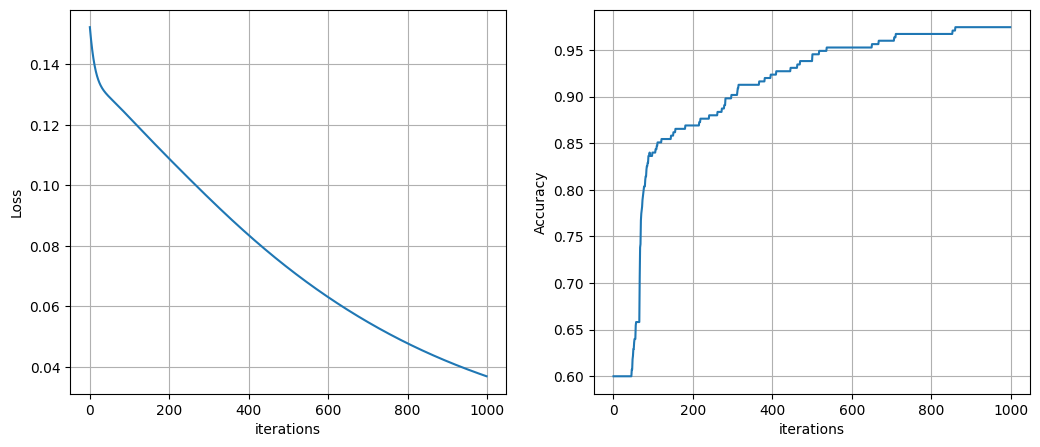

In [12]:
plt.subplot(1, 2, 1)
plt.plot(Avg_Loss)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(Accuracy)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Accuracy')

plt.subplots_adjust(left=0,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()